### Adding Emotion and Mouth position columns to the dataframe

In [3]:
import pandas as pd

df = pd.read_csv('datasets/RADIATE_Color_Faces_AU.csv', index_col=0)

df["emotion"] = df.index
df["emotion"] = df["emotion"].str.extract(r'.*_(.*).bmp')
# extract (.)(.) from the emotion column
temp = df["emotion"].str.extract(r'(.)(.)')

df["emotion"] = temp[0]
df["mouth"] = temp[1]

# if emotion is A, then replace A with angry
df["emotion"] = df["emotion"].replace("A", "angry")
# if emotion is C, then replace H with calm
df["emotion"] = df["emotion"].replace("C", "calm")
# if emotion is D, then replace D with disgust
df["emotion"] = df["emotion"].replace("D", "disgust")
# if emotion is F, then replace F with fear
df["emotion"] = df["emotion"].replace("F", "fear")
# if emotion is H, then replace H with happy
df["emotion"] = df["emotion"].replace("H", "happy")
# if emotion is N, then replace N with neutral
df["emotion"] = df["emotion"].replace("N", "neutral")

# if emotion is S, and mouth is U in the same row, then replace S with surprise
df.loc[(df["emotion"] == "S") & (df["mouth"] == "U"), "emotion"] = "surprise"
# if emotion is S, and mouth is not U in the same row, then replace S with sad
df.loc[(df["emotion"] == "S") & (df["mouth"] != "U"), "emotion"] = "sad"

df = df[df['emotion'] != 'calm']

# if mouth is O, then replace O with open
df["mouth"] = df["mouth"].replace("O", "open")
# if mouth is C, then replace C with closed
df["mouth"] = df["mouth"].replace("C", "closed")
# if mouth is U, then replace U with N/A
df["mouth"] = df["mouth"].replace("U", "N/A")
# if mouth is E, then replace E with exuberant
df["mouth"] = df["mouth"].replace("E", "exuberant")

df = df[df['mouth'] != 'exuberant']
df = df[df['mouth'] != 'N/A']

# create an emotionID column
df["emotionID"] = df["emotion"].astype('category').cat.codes

# create a mouthID column
df["mouthID"] = df["mouth"].astype('category').cat.codes

# put the emotion and emotionID columns and mouth and mouthID columns at the beginning of the dataframe
df = df[["emotion", "emotionID", "mouth", "mouthID"] + [col for col in df.columns if col not in ["emotion", "emotionID", "mouth", "mouthID"]]]

# print first 15 rows
print(df.head(15))

             emotion  emotionID   mouth  mouthID      AU01      AU02  \
AF01_AC.bmp    angry          0  closed        0  0.495898  0.146762   
AF01_AO.bmp    angry          0    open        1  0.282826  0.065132   
AF01_DC.bmp  disgust          1  closed        0  0.290751  0.143386   
AF01_DO.bmp  disgust          1    open        1  0.432929  0.075790   
AF01_FC.bmp     fear          2  closed        0  0.713720  0.474423   
AF01_FO.bmp     fear          2    open        1  0.634923  0.563915   
AF01_HC.bmp    happy          3  closed        0  0.566416  0.156642   
AF01_HO.bmp    happy          3    open        1  0.251061  0.258449   
AF01_NC.bmp  neutral          4  closed        0  0.296070  0.181766   
AF01_NO.bmp  neutral          4    open        1  0.249708  0.105011   
AF01_SC.bmp      sad          5  closed        0  0.188280  0.071396   
AF02_AC.bmp    angry          0  closed        0  0.225689  0.134870   
AF02_AO.bmp    angry          0    open        1  0.183468  0.18

### Missing Values

In [4]:
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
emotion      0
emotionID    0
mouth        0
mouthID      0
AU01         0
AU02         0
AU04         0
AU05         0
AU06         0
AU07         0
AU09         0
AU10         0
AU11         0
AU12         0
AU14         0
AU15         0
AU17         0
AU20         0
AU23         0
AU24         0
AU25         0
AU26         0
AU28         0
AU43         0
dtype: int64


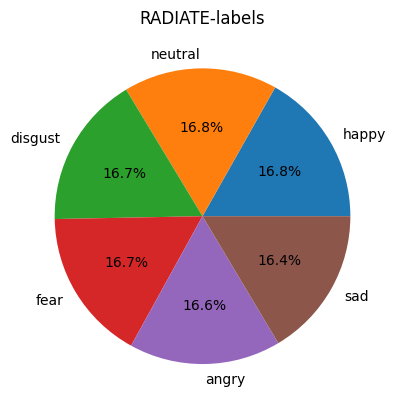

In [5]:
# count the number of occurrences of each emotion in the dataset
emotion_counts = df["emotion"].value_counts()

# plot a pie chart of the number of occurrences of each emotion in the dataset
import matplotlib.pyplot as plt
emotion_counts.plot.pie(autopct="%.1f%%")
plt.title("RADIATE-labels")
plt.ylabel("")
plt.show()

In [6]:
emotion_counts = df["emotion"].value_counts()
emotion_counts # surprise is a bit imbalanced

emotion
happy      218
neutral    218
disgust    216
fear       216
angry      215
sad        213
Name: count, dtype: int64

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# train test split
X = df.drop(columns=["emotion", "emotionID", "mouth"])
y = df["emotionID"]

### Classifier

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

In [9]:
print(f'Samples in training set: {X_train.shape[0]} | Samples in the validation set: {X_val.shape[0]} | Samples in the test set: {X_test.shape[0]}')

Samples in training set: 1049 | Samples in the validation set: 117 | Samples in the test set: 130


In [10]:
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint

input = X.shape[1]
num_classes = len(df['emotion'].unique())

input_layer = keras.layers.Input(shape=(input,))
model = keras.Sequential([
                input_layer,
                keras.layers.Dense(64, activation = 'relu'),
                # keras.layers.Dropout(0.2),
                keras.layers.Dense(32, activation = 'relu'),
                keras.layers.Dense(num_classes, activation = 'softmax')
])

optimizer = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer = optimizer, loss= 'sparse_categorical_crossentropy', metrics= ['accuracy'])

checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max', verbose=1)

model.fit(X_train, y_train, epochs= 100, callbacks=[checkpoint], validation_data=(X_val, y_val))

Epoch 1/100
31/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3549 - loss: 1.5211
Epoch 1: val_accuracy improved from -inf to 0.60684, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.3624 - loss: 1.5054 - val_accuracy: 0.6068 - val_loss: 1.1182
Epoch 2/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.5312 - loss: 1.2276
Epoch 2: val_accuracy improved from 0.60684 to 0.62393, saving model to best_model.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5506 - loss: 1.0818 - val_accuracy: 0.6239 - val_loss: 0.9829
Epoch 3/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.6250 - loss: 0.9641
Epoch 3: val_accuracy did not improve from 0.62393
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6271 - loss: 0.9673 - val_accuracy: 0.6068 - val_loss: 1.0544
Epoch 4/100
 1/33 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5938 - loss: 1.0911
Epoch 4: val_accuracy did not improve from 0.62393
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/

In [11]:
from tensorflow.keras.models import load_model

# Load the best model saved by the checkpoint
best_model = load_model('best_model.keras')

# Evaluate the best model on the test set
best_model.evaluate(X_test, y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5888 - loss: 0.9327  


[0.8999802470207214, 0.6230769157409668]

In [12]:
import numpy as np
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=1)
y_pred_argmax[:5]

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


array([0, 0, 0, 0, 3], dtype=int64)

In [13]:
y_test[:5]

AF12_AC.bmp    0
BF15_DC.bmp    1
AF08_NC.bmp    4
BM14_AC.bmp    0
HF05_HO.bmp    3
Name: emotionID, dtype: int8

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test, y_pred_argmax))

              precision    recall  f1-score   support

           0       0.37      0.33      0.35        21
           1       0.56      0.41      0.47        22
           2       0.76      0.86      0.81        22
           3       0.87      0.91      0.89        22
           4       0.58      0.64      0.61        22
           5       0.39      0.43      0.41        21

    accuracy                           0.60       130
   macro avg       0.59      0.60      0.59       130
weighted avg       0.59      0.60      0.59       130



Text(0.5, 1.0, 'ANN')

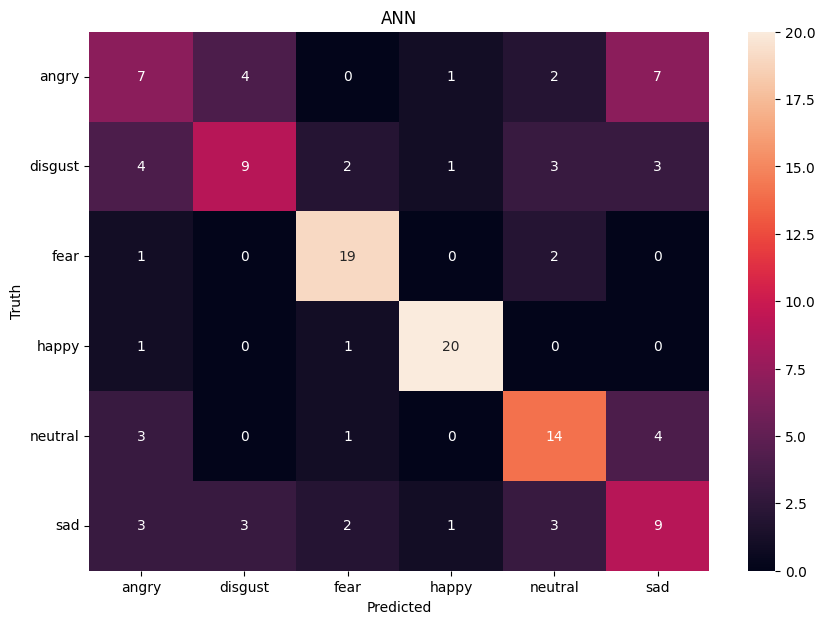

In [19]:
import seaborn as sn
import tensorflow as tf
cm = tf.math.confusion_matrix(labels=y_test,predictions=y_pred_argmax)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xticks(ticks=[i + 0.5 for i in range(len(emotion_counts))], labels=labels)
plt.yticks(ticks=[i + 0.5 for i in range(len(emotion_counts))], labels=labels, rotation=0)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title("ANN")


RandomForestClassifier Accuracy: 0.7


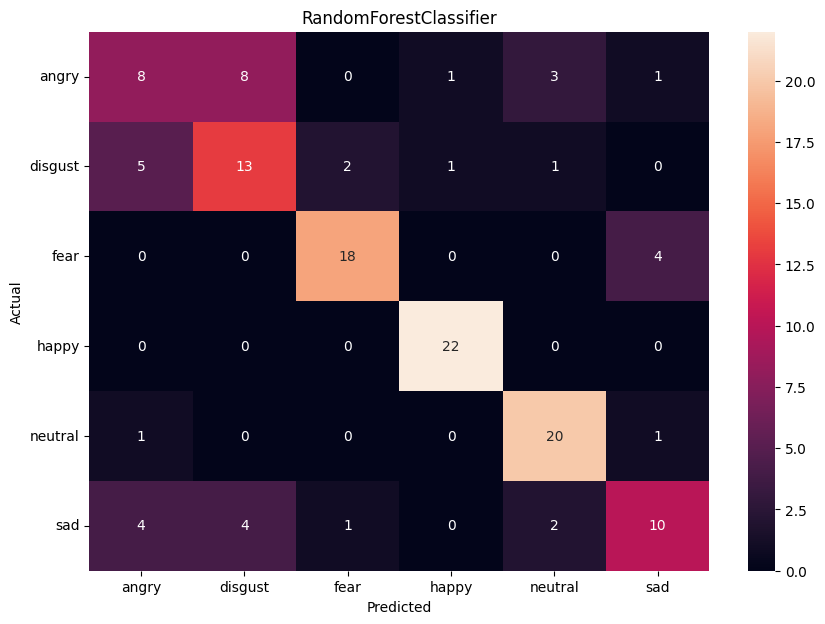

SVC Accuracy: 0.6615384615384615


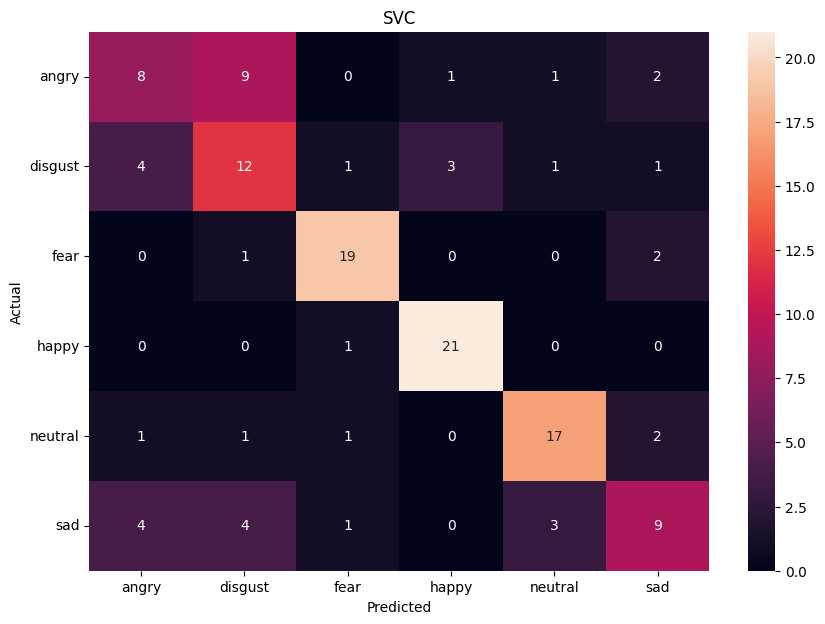

DecisionTreeClassifier Accuracy: 0.5153846153846153


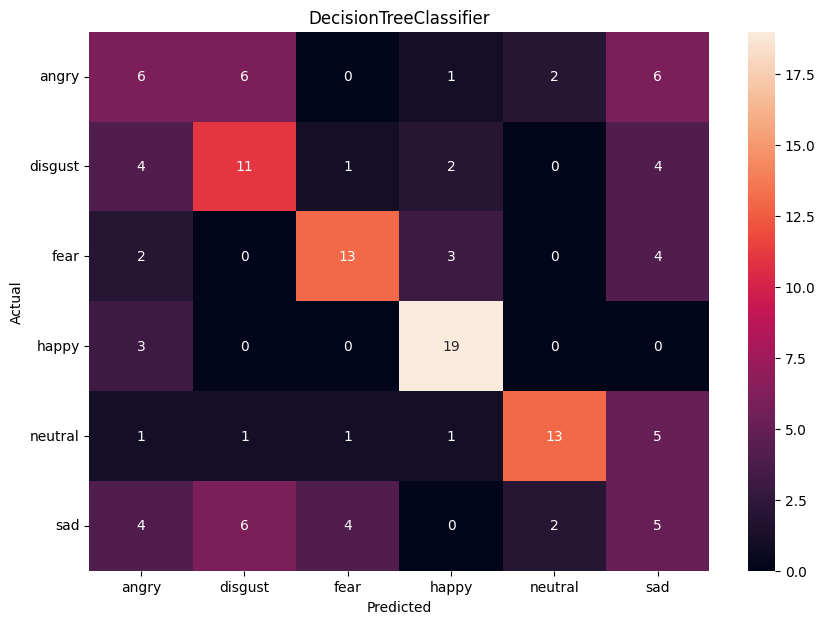

XGBClassifier Accuracy: 0.6615384615384615


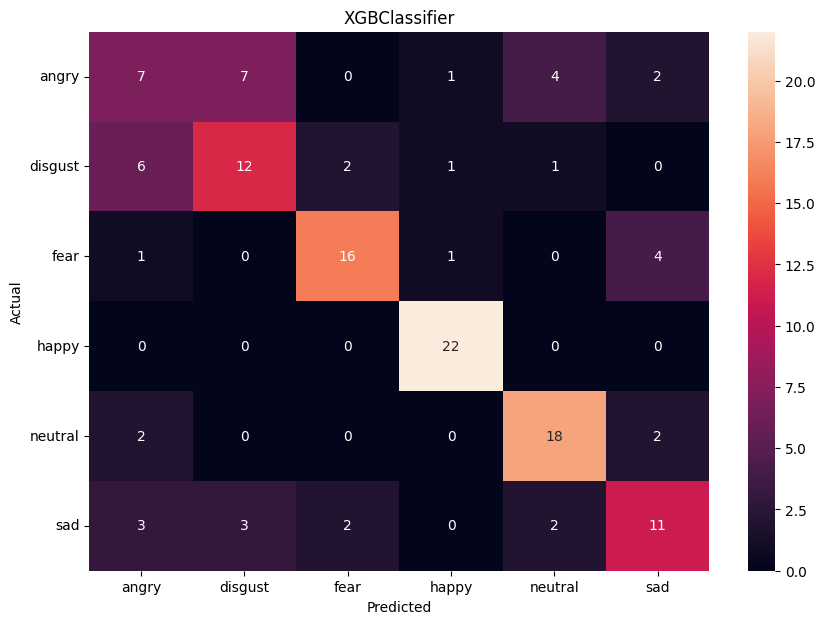

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


# find the best classifier for the dataset, set the random_state to 42
classifiers = [
    RandomForestClassifier(random_state=42),
    SVC(random_state=42),
    DecisionTreeClassifier(random_state=42),
    XGBClassifier(random_state=42)
]

for clf in classifiers:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, "Accuracy:", accuracy_score(y_test, y_pred))

    # plot how many times emotion is predicted correctly
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d")
    # put ticks at the center of each cell
    plt.xticks(ticks=[i + 0.5 for i in range(len(emotion_counts))], labels=labels)
    plt.yticks(ticks=[i + 0.5 for i in range(len(emotion_counts))], labels=labels, rotation=0)

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(clf.__class__.__name__)
    plt.show()

### Feature Importance

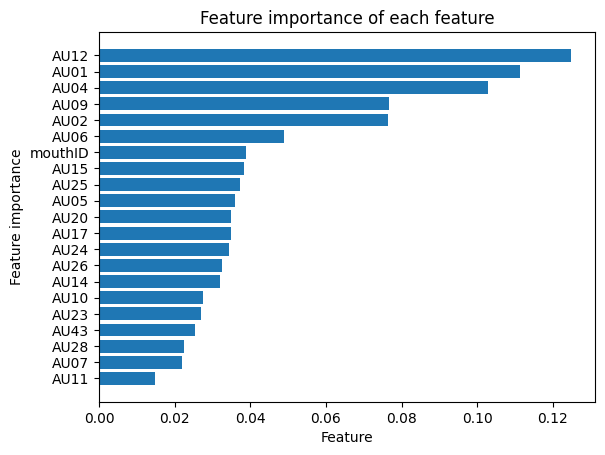

In [17]:
import matplotlib.pyplot as plt

# feature importance
feature_importance = clf.feature_importances_

# plot feature importance
sorted_idx = feature_importance.argsort()
plt.barh(X.columns[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Feature")
plt.ylabel("Feature importance")
plt.title("Feature importance of each feature")
plt.show()